In [6]:
import pandas as pd
import json
import csv
import sys
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import string
import numpy as np
from nltk.corpus import stopwords
import string
import emoji
import regex
import string
from datetime import timedelta
import matplotlib.dates as mdates
import seaborn as sn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from unidecode import unidecode as unidec

In [2]:
dir_="C:\\Users\\Alex\\Personal-Code\\ACE_592_Dating_Sim\\Wrangled_Data\\"

In [7]:
#reads the csv files into memory for each dating app.
#Data has already been cleaed and all three files share the same columns
df_T = pd.read_csv(dir_ + "sent_time_Tinder.csv")
df_T = df_T[['clean_text', 'score', 'date', 'time_stamp', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent']]

df_B = pd.read_csv(dir_ + "sent_time_Bumble.csv")
df_B = df_B[['clean_text', 'score', 'date', 'time_stamp', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent']]

df_H = pd.read_csv(dir_ + "sent_time_Hinge.csv")
df_H = df_H[['clean_text', 'score', 'date', 'time_stamp', 'comp_sent', 'neg_sent', 'pos_sent', 'neu_sent']]

#converts the time_stamp and date columns to datetime64 types
def to_datetime(df):
    df['date'] = pd.to_datetime(df.date)
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    df_data = df.loc[df['score'] != 0]
    return df_data

df_T = to_datetime(df_T)
df_B = to_datetime(df_B)
df_H = to_datetime(df_H)

### Rolling Average Sentiment over Time 

C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\3531811203.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  axs[0].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\3531811203.py:30: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  axs[1].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\3531811203.py:38: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  axs[2].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\3531811203.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error 

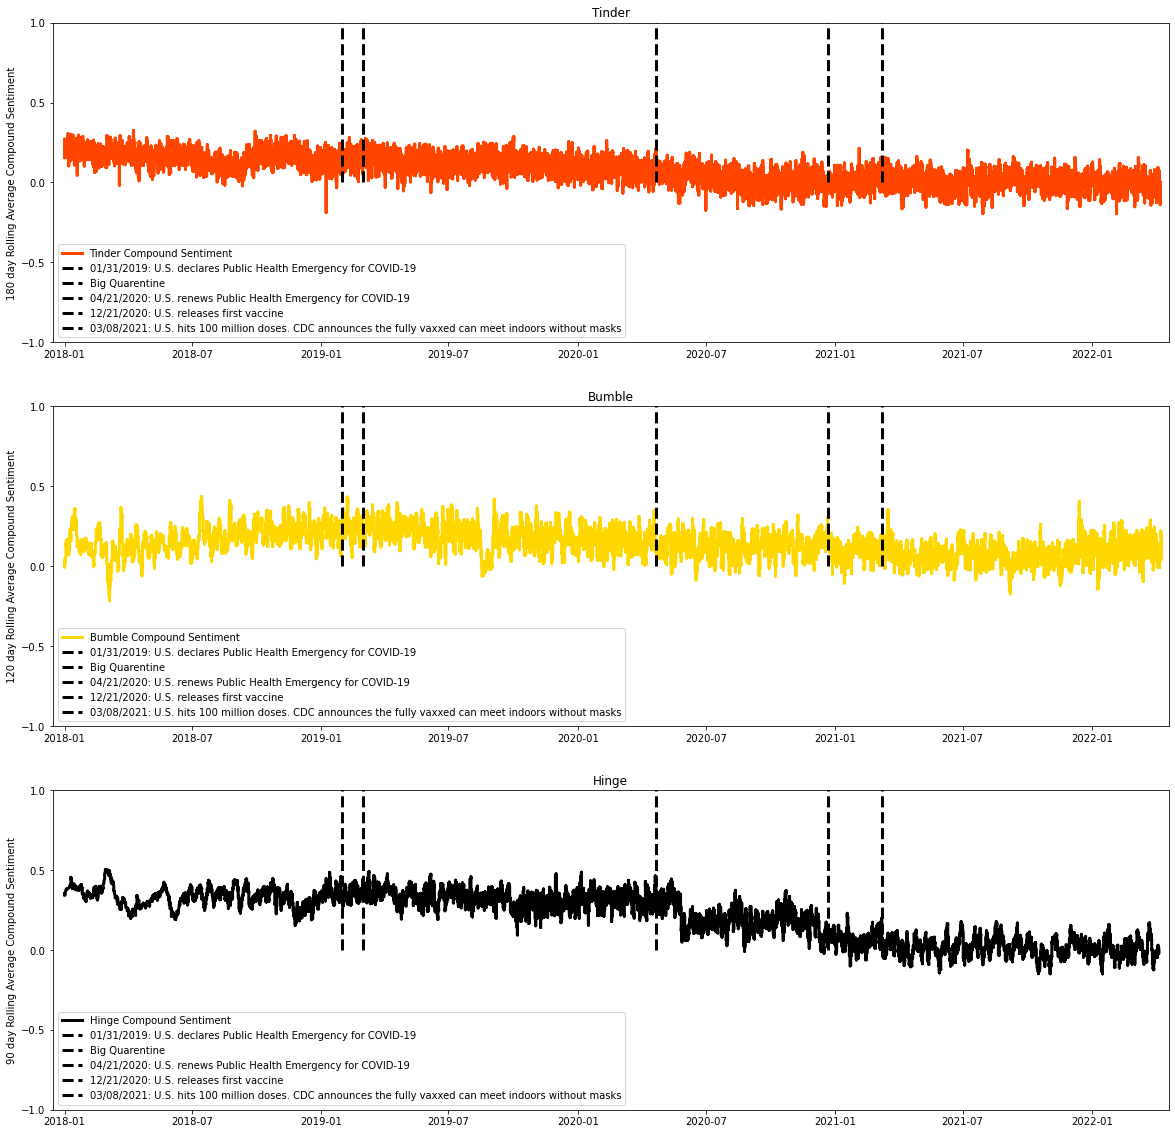

In [38]:
#plots a rolling average of compound sentiment for each app over time

xT = df_T['date']
yT = df_T['comp_sent'].rolling(120).mean()

xB = df_B['date']
yB = df_B['comp_sent'].rolling(90).mean()

xH = df_H['date']
yH = df_H['comp_sent'].rolling(90).mean()

fig, axs = plt.subplots(3, 1, tight_layout=False, 
                        sharey=True, sharex = False,
                        figsize = (20,20))

#tinder
axs[0].plot_date(xT,yT, fmt='-', label="Tinder Compound Sentiment",lw=3, color = 'orangered')
axs[0].title.set_text('Tinder')
axs[0].set_ylabel("180 day Rolling Average Compound Sentiment")
axs[0].set_ylim(-1,1)
axs[0].set_yticks([-1,-0.5,0,0.5,1])
axs[0].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))

#bumble
axs[1].plot_date(xB,yB, fmt='-', label="Bumble Compound Sentiment",lw=3, color = 'gold')
axs[1].title.set_text('Bumble')
axs[1].set_ylabel("120 day Rolling Average Compound Sentiment")
axs[1].set_ylim(-1,1)
axs[1].set_yticks([-1,-0.5,0,0.5,1])
axs[1].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))

#Hinge
axs[2].plot_date(xH,yH, fmt='-', label="Hinge Compound Sentiment",lw=3, color = 'black')
axs[2].title.set_text('Hinge')
axs[2].set_ylabel("90 day Rolling Average Compound Sentiment")
axs[2].set_ylim(-1,1)
axs[2].set_yticks([-1,-0.5,0,0.5,1])
axs[2].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))

#important dates 

#vertical lines dates
x1 = np.datetime64("2019-01-31 00:00:00+00:00")
q = np.datetime64("2019-03-01 00:00:00+00:00")
x2 = np.datetime64("2020-04-21 00:00:00+00:00")
x3 = np.datetime64("2020-12-21 00:00:00+00:00")
x4 = np.datetime64("2021-03-08 00:00:00+00:00")
#x5 = np.datetime64("2021-03-08 00:00:00+00:00")

#US declares COVID emergency
axs[0].vlines(x1, 0, 80, colors='black', label="01/31/2019: U.S. declares Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[1].vlines(x1, 0, 80, colors='black', label="01/31/2019: U.S. declares Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[2].vlines(x1, 0, 80, colors='black', label="01/31/2019: U.S. declares Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')

#big quarentine 
axs[0].vlines(q, 0, 80, colors='black', label="Big Quarentine",lw=3, 
              linestyles='dashed')
axs[1].vlines(q, 0, 80, colors='black', label="Big Quarentine",lw=3, 
              linestyles='dashed')
axs[2].vlines(q, 0, 80, colors='black', label="Big Quarentine",lw=3, 
              linestyles='dashed')

#renewed emergency call
axs[0].vlines(x2, 0, 80, colors='black', label="04/21/2020: U.S. renews Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[1].vlines(x2, 0, 80, colors='black', label="04/21/2020: U.S. renews Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[2].vlines(x2, 0, 80, colors='black', label="04/21/2020: U.S. renews Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')

#vaccines drop first doses
axs[0].vlines(x3, 0, 80, colors='black', label="12/21/2020: U.S. releases first vaccine",lw=3, 
              linestyles='dashed')
axs[1].vlines(x3, 0, 80, colors='black', label="12/21/2020: U.S. releases first vaccine",lw=3, 
              linestyles='dashed')
axs[2].vlines(x3, 0, 80, colors='black', label="12/21/2020: U.S. releases first vaccine",lw=3, 
              linestyles='dashed')

#CDC announces fully vaxxed can meet inside without masks 
axs[0].vlines(x4, 0, 80, colors='black', label="03/08/2021: U.S. hits 100 million doses. CDC announces the fully vaxxed can meet indoors without masks",lw=3, 
              linestyles='dashed')
axs[1].vlines(x4, 0, 80, colors='black', label="03/08/2021: U.S. hits 100 million doses. CDC announces the fully vaxxed can meet indoors without masks",lw=3, 
              linestyles='dashed')
axs[2].vlines(x4, 0, 80, colors='black', label="03/08/2021: U.S. hits 100 million doses. CDC announces the fully vaxxed can meet indoors without masks",lw=3, 
              linestyles='dashed')


axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
axs[2].legend(loc="lower left")
plt.show()

### Now let's overlay the two and see if we can notice any trends.

C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\1200958032.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  axs[0].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\1200958032.py:41: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  axs[1].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\1200958032.py:57: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  axs[2].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
C:\Users\Alex\AppData\Local\Temp\ipykernel_19816\1200958032.py:69: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error 

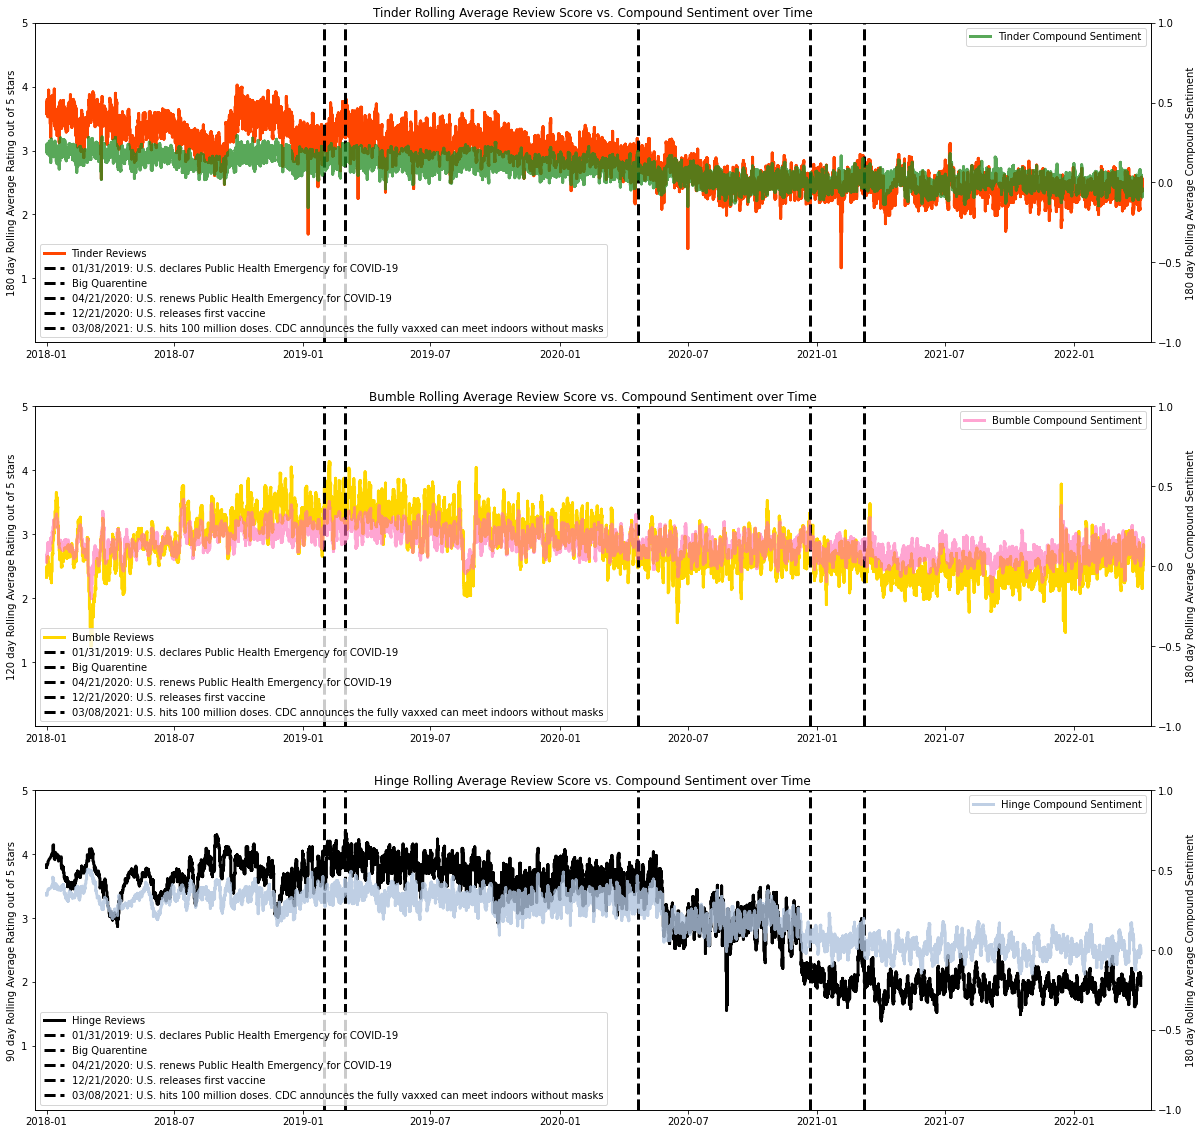

In [39]:
#plots a rolling average of the review scores for each app over time vs rolling average compound sentiment
xT = df_T['date']
yT = df_T['score'].rolling(180).mean()
yT2 = df_T['comp_sent'].rolling(180).mean()

xB = df_B['date']
yB = df_B['score'].rolling(120).mean()
yB2 = df_B['comp_sent'].rolling(120).mean()

xH = df_H['date']
yH = df_H['score'].rolling(90).mean()
yH2 = df_H['comp_sent'].rolling(90).mean()


fig, axs = plt.subplots(3, 1, tight_layout=False, 
                        sharey=True, sharex = False,
                        figsize = (20,20))

#tinder
axs[0].plot_date(xT,yT, fmt='-', label="Tinder Reviews",lw=3, color = 'orangered')
axs[0].title.set_text('Tinder Rolling Average Review Score vs. Compound Sentiment over Time')
axs[0].set_ylabel("180 day Rolling Average Rating out of 5 stars")
axs[0].set_ylim(0,5)
axs[0].set_yticks([1,2,3,4,5])
axs[0].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
#sentiment twin
ax0 = axs[0].twinx()
ax0.plot_date(xT,yT2, fmt='-', label="Tinder Compound Sentiment",lw=3, color = 'forestgreen', alpha = 0.75)
ax0.set_ylim(-1,1)
ax0.set_yticks([-1,-0.5,0,0.5,1])
ax0.set_ylabel("180 day Rolling Average Compound Sentiment")
ax0.legend(loc="upper right")


#bumble
axs[1].plot_date(xB,yB, fmt='-', label="Bumble Reviews",lw=3, color = 'gold')
axs[1].title.set_text('Bumble Rolling Average Review Score vs. Compound Sentiment over Time')
axs[1].set_ylabel("120 day Rolling Average Rating out of 5 stars")
axs[1].set_ylim(0,5)
axs[1].set_yticks([1,2,3,4,5])
axs[1].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
#sentiment twin
ax1 = axs[1].twinx()
ax1.plot_date(xB,yB2, fmt='-', label="Bumble Compound Sentiment",lw=3, color = 'hotpink', alpha = 0.6)
ax1.set_ylim(-1,1)
ax1.set_yticks([-1,-0.5,0,0.5,1])
ax1.set_ylabel("180 day Rolling Average Compound Sentiment")
ax1.legend(loc="upper right")


#Hinge
axs[2].plot_date(xH,yH, fmt='-', label="Hinge Reviews",lw=3, color = 'black')
axs[2].title.set_text('Hinge Rolling Average Review Score vs. Compound Sentiment over Time')
axs[2].set_ylabel("90 day Rolling Average Rating out of 5 stars")
axs[2].set_ylim(0,5)
axs[2].set_yticks([1,2,3,4,5])
axs[2].set_xlim(np.datetime64("2017-12-15 00:00:00+00:00"), np.datetime64("2022-04-20 00:00:00+00:00"))
#sentiment twin
ax2 = axs[2].twinx()
ax2.plot_date(xH,yH2, fmt='-', label="Hinge Compound Sentiment",lw=3, color = 'lightsteelblue', alpha = 0.8)
ax2.set_ylim(-1,1)
ax2.set_yticks([-1,-0.5,0,0.5,1])
ax2.set_ylabel("180 day Rolling Average Compound Sentiment")
ax2.legend(loc="upper right")

#important dates 

#vertical lines dates
x1 = np.datetime64("2019-01-31 00:00:00+00:00")
q = np.datetime64("2019-03-01 00:00:00+00:00")
x2 = np.datetime64("2020-04-21 00:00:00+00:00")
x3 = np.datetime64("2020-12-21 00:00:00+00:00")
x4 = np.datetime64("2021-03-08 00:00:00+00:00")
#x5 = np.datetime64("2021-03-08 00:00:00+00:00")

#US declares COVID emergency
axs[0].vlines(x1, 0, 80, colors='black', label="01/31/2019: U.S. declares Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[1].vlines(x1, 0, 80, colors='black', label="01/31/2019: U.S. declares Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[2].vlines(x1, 0, 80, colors='black', label="01/31/2019: U.S. declares Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')

#big quarentine 
axs[0].vlines(q, 0, 80, colors='black', label="Big Quarentine",lw=3, 
              linestyles='dashed')
axs[1].vlines(q, 0, 80, colors='black', label="Big Quarentine",lw=3, 
              linestyles='dashed')
axs[2].vlines(q, 0, 80, colors='black', label="Big Quarentine",lw=3, 
              linestyles='dashed')

#renewed emergency call
axs[0].vlines(x2, 0, 80, colors='black', label="04/21/2020: U.S. renews Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[1].vlines(x2, 0, 80, colors='black', label="04/21/2020: U.S. renews Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')
axs[2].vlines(x2, 0, 80, colors='black', label="04/21/2020: U.S. renews Public Health Emergency for COVID-19",lw=3, 
              linestyles='dashed')

#vaccines drop first doses
axs[0].vlines(x3, 0, 80, colors='black', label="12/21/2020: U.S. releases first vaccine",lw=3, 
              linestyles='dashed')
axs[1].vlines(x3, 0, 80, colors='black', label="12/21/2020: U.S. releases first vaccine",lw=3, 
              linestyles='dashed')
axs[2].vlines(x3, 0, 80, colors='black', label="12/21/2020: U.S. releases first vaccine",lw=3, 
              linestyles='dashed')

#CDC announces fully vaxxed can meet inside without masks 
axs[0].vlines(x4, 0, 80, colors='black', label="03/08/2021: U.S. hits 100 million doses. CDC announces the fully vaxxed can meet indoors without masks",lw=3, 
              linestyles='dashed')
axs[1].vlines(x4, 0, 80, colors='black', label="03/08/2021: U.S. hits 100 million doses. CDC announces the fully vaxxed can meet indoors without masks",lw=3, 
              linestyles='dashed')
axs[2].vlines(x4, 0, 80, colors='black', label="03/08/2021: U.S. hits 100 million doses. CDC announces the fully vaxxed can meet indoors without masks",lw=3, 
              linestyles='dashed')


axs[0].legend(loc="lower left")
axs[1].legend(loc="lower left")
axs[2].legend(loc="lower left")
plt.show()